In [1]:
# data management
import numpy as np                   # for linear algebra
import pandas as pd                  # for tabular data manipulation and processing
import category_encoders             # for categorical encoding

# machine learning
import sklearn                       # for data prep and classical ML

# data visualization and graphics
import matplotlib.pyplot as plt      # for visualization fundamentals
import seaborn as sns                # for pretty visualizations
sns.set_palette("magma")

# misc
import math                          # for calculation
import sys                           # for system manipulation
import os                            # for file manipulation

# stats
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint

In [2]:
# Load Dataset

file_path = "/Users/Sebastiano/data/Clinical_MRI.xlsx"
db = pd.read_excel(file_path)
pd.set_option('display.max_columns', None)

print("N° of patients: {}".format(len(db)))
print("N° of columns: {}".format(db.shape[1]))
db.head()

N° of patients: 27
N° of columns: 969


,Patient,Date of Birth,Gender,Education,Disease duration (months),Age,SLEDAI-2k (at the time of NP event),PGA (at the time of fMRI),SLICC-DI (at the time of NP event),anti-dsDNA Titre (0=absent; 1=present) ),anti-dsDNA Titre (insert NV here <7 ),Anti-Ro-SSA,Anti-La-SSB,Anti-RNP,anti-Sm,C3 (mgdl),C4 (mgdl),aPL syndrome,LAC,aCL IgG,aCL IgM,aB2GPI IgG,aB2GPI IgM,aPL+,No Treatment,Antiplatelet,Anticoagulant,Prednisone (mg equivalent),Antimalarial,Immunosuppressant,Biologic,AnAb,Anti-Rib-P,Anti-DWEYS,NP-SLE,Event,Livedo reticularis,Cutaneous vasculitis,Hypertension,Hyperlipidaemia,current Smoking,ever smoking,Scale factor,SNR,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,Normal Appearing White Matter volume %,Abnormal Appearing White Matter volume cm3,Abnormal Appearing White Matter volume %,Grey Matter (GM) volume cm3,Grey Matter (GM) volume %,Subcortical Grey Matter volume cm3,Subcortical Grey Matter volume %,Cortical Grey Matter volume cm3,Cortical Grey Matter volume %,Cerebellar Grey Matter volume cm3,Cerebellar Grey Matter volume %,Cerebro Spinal Fluid (CSF) volume cm3,Cerebro Spinal Fluid (CSF) volume %,Brain (WM+GM) volume cm3,Brain (WM+GM) volume %,Intracranial Cavity (IC) volume cm3,Intracranial Cavity (IC) volume %,Cerebrum total volume cm3,Cerebrum total volume %,Cerebrum right volume cm3,Cerebrum right volume %,Cerebrum left volume cm3,Cerebrum left volume %,Cerebrum volume asymmetry,Cerebrum WM total volume cm3,Cerebrum WM total volume %,Cerebrum WM right volume cm3,Cerebrum WM right volume %,Cerebrum WM left volume cm3,Cerebrum WM left volume %,Cerebrum WM volume asymmetry,Cerebrum GM total volume cm3,Cerebrum GM total volume %,Cerebrum GM right volume cm3,Cerebrum GM right volume %,Cerebrum GM left volume cm3,Cerebrum GM left volume %,Cerebrum GM volume asymmetry,Cerebellum total volume cm3,Cerebellum total volume %,Cerebellum right volume cm3,Cerebellum right volume %,Cerebellum left volume cm3,Cerebellum left volume %,Cerebellum volume asymmetry,Cerebellum WM total volume cm3,Cerebellum WM total volume %,Cerebellum WM right volume cm3,Cerebellum WM right volume %,Cerebellum WM left volume cm3,Cerebellum WM left volume %,Cerebellum WM volume asymmetry,Cerebellum GM total volume cm3,Cerebellum GM total volume %,Cerebellum GM right volume cm3,Cerebellum GM right volume %,Cerebellum GM left volume cm3,Cerebellum GM left volume %,Cerebellum GM volume asymmetry,Vermis volume cm3,Vermis volume %,Brainstem volume cm3,Brainstem volume %,Accumbens total volume cm3,Accumbens total volume %,Accumbens right volume cm3,Accumbens right volume %,Accumbens left volume cm3,Accumbens left volume %,Accumbens volume asymmetry,Amygdala total volume cm3,Amygdala total volume %,Amygdala right volume cm3,Amygdala right volume %,Amygdala left volume cm3,Amygdala left volume %,Amygdala volume asymmetry,Basal Forebrain total volume cm3,Basal Forebrain total volume %,Basal Forebrain right volume cm3,Basal Forebrain right volume %,Basal Forebrain left volume cm3,Basal Forebrain left volume %,Basal Forebrain volume asymmetry,Caudate total volume cm3,Caudate total volume %,Caudate right volume cm3,Caudate right volume %,Caudate left volume cm3,Caudate left volume %,Caudate volume asymmetry,Hippocampus total volume cm3,Hippocampus total volume %,Hippocampus right volume cm3,Hippocampus right volume %,Hippocampus left volume cm3,Hippocampus left volume %,Hippocampus volume asymmetry,Pallidum total volume cm3,Pallidum total volume %,Pallidum right volume cm3,Pallidum right volume %,Pallidum left volume cm3,Pallidum left volume %,Pallidum volume asymmetry,Putamen total volume cm3,Putamen total volume %,Putamen right volume cm3,Putamen right volume %,Putamen left volume cm3,Putamen left volume %,Putamen volume asymmetry,Thalamus total volume cm3,Thalamus total volume %,Thalamus right volume cm3,Thalamus right volume %,Thalamus left volume cm3,Thalamus left volume %,Thalamus volume asymmetry,Ventral DC

In [3]:
# Drop unwanted columns

df = db.drop(['Patient','Date of Birth', 'Gender', 'Education', 'Age'], axis = 'columns')
# drop columns that include "%" in their name
#cols_to_drop = [col for col in df.columns if "%" in col]
#df = df.drop(columns=cols_to_drop)
print("Effective features to consider: {} ".format(len(df.columns)-1))

Effective features to consider: 963 


In [4]:
# One Hot Encoding for Scores, Antiplatelets and Coagulants, Therapy, NP Event

from sklearn.preprocessing import OneHotEncoder

categ = ['Antiplatelet', 'Anticoagulant', 'Antimalarial', 'Immunosuppressant', 'Biologic', 'Event']
ohe = OneHotEncoder(categories='auto',sparse=False)
df_enc = ohe.fit_transform(df[categ])
df_enc = pd.DataFrame(df_enc,columns=ohe.get_feature_names_out(categ))
df = pd.concat([df, df_enc], axis=1)
df = df.drop(categ, axis=1)
df.tail()

/opt/homebrew/Caskroom/miniforge/base/envs/lupus/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Disease duration (months),SLEDAI-2k (at the time of NP event),PGA (at the time of fMRI),SLICC-DI (at the time of NP event),anti-dsDNA Titre (0=absent; 1=present) ),anti-dsDNA Titre (insert NV here <7 ),Anti-Ro-SSA,Anti-La-SSB,Anti-RNP,anti-Sm,C3 (mgdl),C4 (mgdl),aPL syndrome,LAC,aCL IgG,aCL IgM,aB2GPI IgG,aB2GPI IgM,aPL+,No Treatment,Prednisone (mg equivalent),AnAb,Anti-Rib-P,Anti-DWEYS,NP-SLE,Livedo reticularis,Cutaneous vasculitis,Hypertension,Hyperlipidaemia,current Smoking,ever smoking,Scale factor,SNR,White Matter (WM) volume cm3,White Matter (WM) volume %,Normal Appearing White Matter volume cm3,Normal Appearing White Matter volume %,Abnormal Appearing White Matter volume cm3,Abnormal Appearing White Matter volume %,Grey Matter (GM) volume cm3,Grey Matter (GM) volume %,Subcortical Grey Matter volume cm3,Subcortical Grey Matter volume %,Cortical Grey Matter volume cm3,Cortical Grey Matter volume %,Cerebellar Grey Matter volume cm3,Cerebellar Grey Matter volume %,Cerebro Spinal Fluid (CSF) volume cm3,Cerebro Spinal Fluid (CSF) volume %,Brain (WM+GM) volume cm3,Brain (WM+GM) volume %,Intracranial Cavity (IC) volume cm3,Intracranial Cavity (IC) volume %,Cerebrum total volume cm3,Cerebrum total volume %,Cerebrum right volume cm3,Cerebrum right volume %,Cerebrum left volume cm3,Cerebrum left volume %,Cerebrum volume asymmetry,Cerebrum WM total volume cm3,Cerebrum WM total volume %,Cerebrum WM right volume cm3,Cerebrum WM right volume %,Cerebrum WM left volume cm3,Cerebrum WM left volume %,Cerebrum WM volume asymmetry,Cerebrum GM total volume cm3,Cerebrum GM total volume %,Cerebrum GM right volume cm3,Cerebrum GM right volume %,Cerebrum GM left volume cm3,Cerebrum GM left volume %,Cerebrum GM volume asymmetry,Cerebellum total volume cm3,Cerebellum total volume %,Cerebellum right volume cm3,Cerebellum right volume %,Cerebellum left volume cm3,Cerebellum left volume %,Cerebellum volume asymmetry,Cerebellum WM total volume cm3,Cerebellum WM total volume %,Cerebellum WM right volume cm3,Cerebellum WM right volume %,Cerebellum WM left volume cm3,Cerebellum WM left volume %,Cerebellum WM volume asymmetry,Cerebellum GM total volume cm3,Cerebellum GM total volume %,Cerebellum GM right volume cm3,Cerebellum GM right volume %,Cerebellum GM left volume cm3,Cerebellum GM left volume %,Cerebellum GM volume asymmetry,Vermis volume cm3,Vermis volume %,Brainstem volume cm3,Brainstem volume %,Accumbens total volume cm3,Accumbens total volume %,Accumbens right volume cm3,Accumbens right volume %,Accumbens left volume cm3,Accumbens left volume %,Accumbens volume asymmetry,Amygdala total volume cm3,Amygdala total volume %,Amygdala right volume cm3,Amygdala right volume %,Amygdala left volume cm3,Amygdala left volume %,Amygdala volume asymmetry,Basal Forebrain total volume cm3,Basal Forebrain total volume %,Basal Forebrain right volume cm3,Basal Forebrain right volume %,Basal Forebrain left volume cm3,Basal Forebrain left volume %,Basal Forebrain volume asymmetry,Caudate total volume cm3,Caudate total volume %,Caudate right volume cm3,Caudate right volume %,Caudate left volume cm3,Caudate left volume %,Caudate volume asymmetry,Hippocampus total volume cm3,Hippocampus total volume %,Hippocampus right volume cm3,Hippocampus right volume %,Hippocampus left volume cm3,Hippocampus left volume %,Hippocampus volume asymmetry,Pallidum total volume cm3,Pallidum total volume %,Pallidum right volume cm3,Pallidum right volume %,Pallidum left volume cm3,Pallidum left volume %,Pallidum volume asymmetry,Putamen total volume cm3,Putamen total volume %,Putamen right volume cm3,Putamen right volume %,Putamen left volume cm3,Putamen left volume %,Putamen volume asymmetry,Thalamus total volume cm3,Thalamus total volume %,Thalamus right volume cm3,Thalamus right volume %,Thalamus left volume cm3,Thalamus left volume %,Thalamus volume asymmetry,Ventral DC total volume cm3,Ventral DC total volume %,Ventral DC right volume cm3,Ventral DC right volume %,Ventral DC left vo

# Partial Correlations

## NP-SLE

In [ ]:
from scipy.stats import pearsonr
import pingouin as pg

df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)
# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Abnormal Appearing White Matter volume cm3'
prednisone = 'prednisone_cat'
sledai = 'SLEDAI_cat'

# Compute the correlations
for col in neurocog_cols + [lesion_load]:
    # Compute the Pearson correlation between each neurocognitive domain and lesion load
    r, p = pearsonr(df[col], df[lesion_load])
    print(f'{col} vs {lesion_load}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    if col != lesion_load:
        partial_corr_results = pg.partial_corr(data=df, x=col, y=lesion_load, covar=[prednisone, sledai])
        r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
        print(f'{col} vs {lesion_load} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
        assert abs(r - r_partial) > 1e-10, f'{col} and {lesion_load} are perfectly correlated'

    # Compute the Pearson correlation between total neurocognitive score and lesion load
    r_total, p_total = pearsonr(df['NP-SLE'], df[lesion_load])
    print(f'total_neurocog vs {lesion_load}: r = {r_total:.2f}, p = {p_total:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    total_partial_results = pg.partial_corr(data=df, x='NP-SLE', y=lesion_load, covar=[prednisone, sledai])
    r_total_partial, p_total_partial = total_partial_results['r'][0], total_partial_results['p-val'][0]
    print(f'NP-SLE vs {lesion_load} (partial corr): r = {r_total_partial:.2f}, p = {p_total_partial:.2f}')


    # Plot the scatter plot
    plt.figure()
    plt.scatter(df[col], df[lesion_load])
    plt.xlabel(col)
    plt.ylabel(lesion_load)
    plt.title(f'{col} vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot
    plt.figure()
    sns.lmplot(data=df, x=col, y=lesion_load, hue=prednisone, col=sledai, col_wrap=3)
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()
    
    colors = ['red' if p == 0 else 'blue' for p in df[prednisone]]
    # Plot the scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    plt.scatter(df['NP-SLE'], df[lesion_load], c=colors)
    plt.xlabel('NP-SLE')
    plt.ylabel(lesion_load)
    plt.title(f'NP-SLE vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    sns.lmplot(data=df, x='NP-SLE', y=lesion_load, ci=None, scatter_kws={"s": 10})
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()

In [ ]:
from scipy.stats import pearsonr
import pingouin as pg

df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)
# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'SCA thickness asymmetry'
prednisone = 'prednisone_cat'
sledai = 'SLEDAI_cat'

# Compute the correlations
for col in neurocog_cols + [lesion_load]:
    # Compute the Pearson correlation between each neurocognitive domain and lesion load
    r, p = pearsonr(df[col], df[lesion_load])
    print(f'{col} vs {lesion_load}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    if col != lesion_load:
        partial_corr_results = pg.partial_corr(data=df, x=col, y=lesion_load, covar=[prednisone, sledai])
        r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
        print(f'{col} vs {lesion_load} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
        assert abs(r - r_partial) > 1e-10, f'{col} and {lesion_load} are perfectly correlated'

    # Compute the Pearson correlation between total neurocognitive score and lesion load
    r_total, p_total = pearsonr(df['NP-SLE'], df[lesion_load])
    print(f'total_neurocog vs {lesion_load}: r = {r_total:.2f}, p = {p_total:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    total_partial_results = pg.partial_corr(data=df, x='NP-SLE', y=lesion_load, covar=[prednisone, sledai])
    r_total_partial, p_total_partial = total_partial_results['r'][0], total_partial_results['p-val'][0]
    print(f'NP-SLE vs {lesion_load} (partial corr): r = {r_total_partial:.2f}, p = {p_total_partial:.2f}')


    # Plot the scatter plot
    plt.figure()
    plt.scatter(df[col], df[lesion_load])
    plt.xlabel(col)
    plt.ylabel(lesion_load)
    plt.title(f'{col} vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot
    plt.figure()
    sns.lmplot(data=df, x=col, y=lesion_load, hue=prednisone, col=sledai, col_wrap=3)
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()
    
    colors = ['red' if p == 0 else 'blue' for p in df[prednisone]]
    # Plot the scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    plt.scatter(df['NP-SLE'], df[lesion_load], c=colors)
    plt.xlabel('NP-SLE')
    plt.ylabel(lesion_load)
    plt.title(f'NP-SLE vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    sns.lmplot(data=df, x='NP-SLE', y=lesion_load, ci=None, scatter_kws={"s": 10})
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()

In [ ]:
from scipy.stats import pearsonr
import pingouin as pg

df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)
# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Amygdala right volume %'
prednisone = 'prednisone_cat'
sledai = 'SLEDAI_cat'

# Compute the correlations
for col in neurocog_cols + [lesion_load]:
    # Compute the Pearson correlation between each neurocognitive domain and lesion load
    r, p = pearsonr(df[col], df[lesion_load])
    print(f'{col} vs {lesion_load}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    if col != lesion_load:
        partial_corr_results = pg.partial_corr(data=df, x=col, y=lesion_load, covar=[prednisone, sledai])
        r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
        print(f'{col} vs {lesion_load} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
        assert abs(r - r_partial) > 1e-10, f'{col} and {lesion_load} are perfectly correlated'

    # Compute the Pearson correlation between total neurocognitive score and lesion load
    r_total, p_total = pearsonr(df['NP-SLE'], df[lesion_load])
    print(f'total_neurocog vs {lesion_load}: r = {r_total:.2f}, p = {p_total:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    total_partial_results = pg.partial_corr(data=df, x='NP-SLE', y=lesion_load, covar=[prednisone, sledai])
    r_total_partial, p_total_partial = total_partial_results['r'][0], total_partial_results['p-val'][0]
    print(f'NP-SLE vs {lesion_load} (partial corr): r = {r_total_partial:.2f}, p = {p_total_partial:.2f}')


    # Plot the scatter plot
    plt.figure()
    plt.scatter(df[col], df[lesion_load])
    plt.xlabel(col)
    plt.ylabel(lesion_load)
    plt.title(f'{col} vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot
    plt.figure()
    sns.lmplot(data=df, x=col, y=lesion_load, hue=prednisone, col=sledai, col_wrap=3)
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()
    
    colors = ['red' if p == 0 else 'blue' for p in df[prednisone]]
    # Plot the scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    plt.scatter(df['NP-SLE'], df[lesion_load], c=colors)
    plt.xlabel('NP-SLE')
    plt.ylabel(lesion_load)
    plt.title(f'NP-SLE vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    sns.lmplot(data=df, x='NP-SLE', y=lesion_load, ci=None, scatter_kws={"s": 10})
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()

In [ ]:
from scipy.stats import pearsonr
import pingouin as pg

df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)
# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Temporal thickness asymmetry'
prednisone = 'prednisone_cat'
sledai = 'SLEDAI_cat'

# Compute the correlations
for col in neurocog_cols + [lesion_load]:
    # Compute the Pearson correlation between each neurocognitive domain and lesion load
    r, p = pearsonr(df[col], df[lesion_load])
    print(f'{col} vs {lesion_load}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    if col != lesion_load:
        partial_corr_results = pg.partial_corr(data=df, x=col, y=lesion_load, covar=[prednisone, sledai])
        r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
        print(f'{col} vs {lesion_load} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
        assert abs(r - r_partial) > 1e-10, f'{col} and {lesion_load} are perfectly correlated'

    # Compute the Pearson correlation between total neurocognitive score and lesion load
    r_total, p_total = pearsonr(df['NP-SLE'], df[lesion_load])
    print(f'total_neurocog vs {lesion_load}: r = {r_total:.2f}, p = {p_total:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    total_partial_results = pg.partial_corr(data=df, x='NP-SLE', y=lesion_load, covar=[prednisone, sledai])
    r_total_partial, p_total_partial = total_partial_results['r'][0], total_partial_results['p-val'][0]
    print(f'NP-SLE vs {lesion_load} (partial corr): r = {r_total_partial:.2f}, p = {p_total_partial:.2f}')


    # Plot the scatter plot
    plt.figure()
    plt.scatter(df[col], df[lesion_load])
    plt.xlabel(col)
    plt.ylabel(lesion_load)
    plt.title(f'{col} vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot
    plt.figure()
    sns.lmplot(data=df, x=col, y=lesion_load, hue=prednisone, col=sledai, col_wrap=3)
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()
    
    colors = ['red' if p == 0 else 'blue' for p in df[prednisone]]
    # Plot the scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    plt.scatter(df['NP-SLE'], df[lesion_load], c=colors)
    plt.xlabel('NP-SLE')
    plt.ylabel(lesion_load)
    plt.title(f'NP-SLE vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    sns.lmplot(data=df, x='NP-SLE', y=lesion_load, ci=None, scatter_kws={"s": 10})
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()

In [ ]:
from scipy.stats import pearsonr
import pingouin as pg

df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)
# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'TMP thickness asymmetry'
prednisone = 'prednisone_cat'
sledai = 'SLEDAI_cat'

# Compute the correlations
for col in neurocog_cols + [lesion_load]:
    # Compute the Pearson correlation between each neurocognitive domain and lesion load
    r, p = pearsonr(df[col], df[lesion_load])
    print(f'{col} vs {lesion_load}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    if col != lesion_load:
        partial_corr_results = pg.partial_corr(data=df, x=col, y=lesion_load, covar=[prednisone, sledai])
        r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
        print(f'{col} vs {lesion_load} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
        assert abs(r - r_partial) > 1e-10, f'{col} and {lesion_load} are perfectly correlated'

    # Compute the Pearson correlation between total neurocognitive score and lesion load
    r_total, p_total = pearsonr(df['NP-SLE'], df[lesion_load])
    print(f'total_neurocog vs {lesion_load}: r = {r_total:.2f}, p = {p_total:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    total_partial_results = pg.partial_corr(data=df, x='NP-SLE', y=lesion_load, covar=[prednisone, sledai])
    r_total_partial, p_total_partial = total_partial_results['r'][0], total_partial_results['p-val'][0]
    print(f'NP-SLE vs {lesion_load} (partial corr): r = {r_total_partial:.2f}, p = {p_total_partial:.2f}')


    # Plot the scatter plot
    plt.figure()
    plt.scatter(df[col], df[lesion_load])
    plt.xlabel(col)
    plt.ylabel(lesion_load)
    plt.title(f'{col} vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot
    plt.figure()
    sns.lmplot(data=df, x=col, y=lesion_load, hue=prednisone, col=sledai, col_wrap=3)
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()
    
    colors = ['red' if p == 0 else 'blue' for p in df[prednisone]]
    # Plot the scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    plt.scatter(df['NP-SLE'], df[lesion_load], c=colors)
    plt.xlabel('NP-SLE')
    plt.ylabel(lesion_load)
    plt.title(f'NP-SLE vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    sns.lmplot(data=df, x='NP-SLE', y=lesion_load, ci=None, scatter_kws={"s": 10})
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()

In [ ]:
from scipy.stats import pearsonr
import pingouin as pg

df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)
# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'MTG thickness asymmetry'
prednisone = 'prednisone_cat'
sledai = 'SLEDAI_cat'

# Compute the correlations
for col in neurocog_cols + [lesion_load]:
    # Compute the Pearson correlation between each neurocognitive domain and lesion load
    r, p = pearsonr(df[col], df[lesion_load])
    print(f'{col} vs {lesion_load}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    if col != lesion_load:
        partial_corr_results = pg.partial_corr(data=df, x=col, y=lesion_load, covar=[prednisone, sledai])
        r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
        print(f'{col} vs {lesion_load} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
        assert abs(r - r_partial) > 1e-10, f'{col} and {lesion_load} are perfectly correlated'

    # Compute the Pearson correlation between total neurocognitive score and lesion load
    r_total, p_total = pearsonr(df['NP-SLE'], df[lesion_load])
    print(f'total_neurocog vs {lesion_load}: r = {r_total:.2f}, p = {p_total:.2f}')

    # Compute the partial correlation adjusting for prednisone and SLEDAI
    total_partial_results = pg.partial_corr(data=df, x='NP-SLE', y=lesion_load, covar=[prednisone, sledai])
    r_total_partial, p_total_partial = total_partial_results['r'][0], total_partial_results['p-val'][0]
    print(f'NP-SLE vs {lesion_load} (partial corr): r = {r_total_partial:.2f}, p = {p_total_partial:.2f}')


    # Plot the scatter plot
    plt.figure()
    plt.scatter(df[col], df[lesion_load])
    plt.xlabel(col)
    plt.ylabel(lesion_load)
    plt.title(f'{col} vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot
    plt.figure()
    sns.lmplot(data=df, x=col, y=lesion_load, hue=prednisone, col=sledai, col_wrap=3)
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()
    
    colors = ['red' if p == 0 else 'blue' for p in df[prednisone]]
    # Plot the scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    plt.scatter(df['NP-SLE'], df[lesion_load], c=colors)
    plt.xlabel('NP-SLE')
    plt.ylabel(lesion_load)
    plt.title(f'NP-SLE vs {lesion_load}')
    plt.show()

    # Plot the partial scatter plot of total neurocognitive score vs lesion load
    plt.figure()
    sns.lmplot(data=df, x='NP-SLE', y=lesion_load, ci=None, scatter_kws={"s": 10})
    plt.title(f'{col} vs {lesion_load} (partial corr)')
    plt.show()

## SLEDAI

Event_CVA vs SLEDAI-2k (at the time of NP event): r = -0.16, p = 0.41
Event_CVA vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.28, p = 0.18
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event): r = 0.16, p = 0.42
Event_Mood abnormalities (depressive) vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.69
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event): r = 0.22, p = 0.28
Event_Mood abnormalities (mixed) vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.03, p = 0.90
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event): r = 0.13, p = 0.53
Event_Movement Disorder vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.08, p = 0.72
Event_Psychosis vs SLEDAI-2k (at the time of NP event): r = 0.17, p = 0.39
Event_Psychosis vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.02, p = 0.93
Event_Seizure vs SLEDAI-2k (at the time of NP event): r = -0.04, p = 0.85
Event_Seizure 

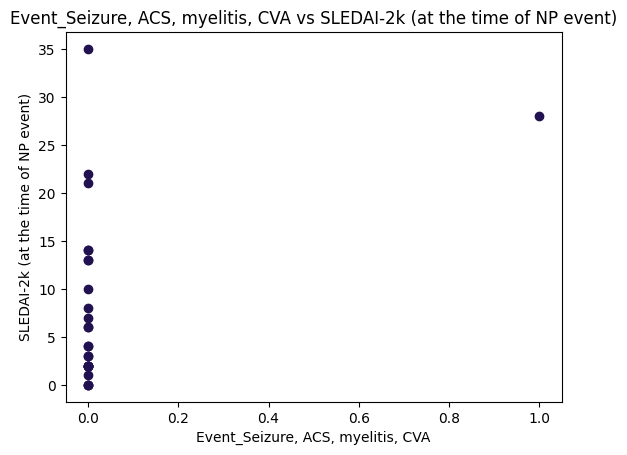

<Figure size 640x480 with 0 Axes>

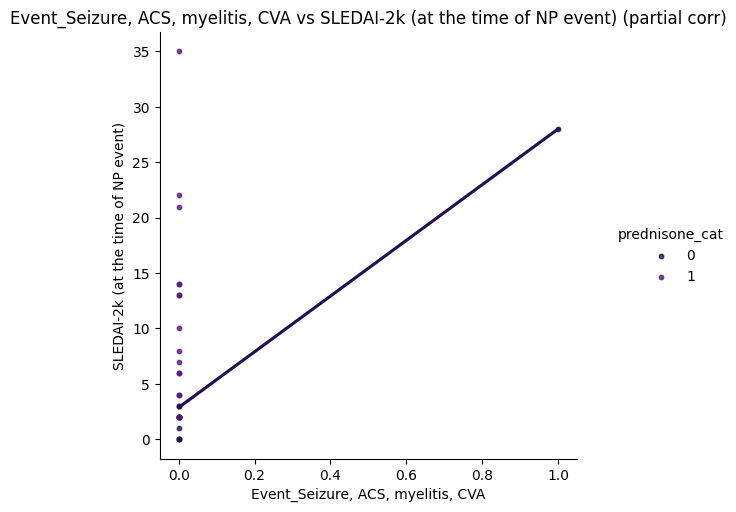

In [13]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'IOG volume asymmetry'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'

## Compute the correlations
for col in neurocog_cols:
    # Compute the Pearson correlation between each neurocognitive domain and SLEDAI
    r, p = spearmanr(df[col], df[sledai])
    print(f'{col} vs {sledai}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and NP-SLE
    partial_corr_results = pg.partial_corr(data=df, x=col, y=sledai, covar=[prednisone, np_sle])
    r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
    print(f'{col} vs {sledai} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
    assert abs(r - r_partial) > 1e-10, f'{col} and {sledai} are perfectly correlated'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


# Plot the scatter plot
plt.figure()
plt.scatter(df[col], df[sledai])
plt.xlabel(col)
plt.ylabel(sledai)
plt.title(f'{col} vs {sledai}')
plt.show()

# Plot the partial scatter plot
plt.figure()
sns.lmplot(data=df, x=col, y=sledai, hue=prednisone, ci=None, scatter_kws={"s": 10})
plt.title(f'{col} vs {sledai} (partial corr)')
plt.show()


In [34]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Calc total volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'
   
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

Calc total volume % vs SLEDAI-2k (at the time of NP event): r = 0.39, p = 0.04
Calc total volume % vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.48, p = 0.02


In [35]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Amygdala total volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'
 
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

Amygdala total volume % vs SLEDAI-2k (at the time of NP event): r = 0.38, p = 0.05
Amygdala total volume % vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.21, p = 0.31


In [36]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Amygdala left volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'

# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


Amygdala left volume % vs SLEDAI-2k (at the time of NP event): r = 0.35, p = 0.07
Amygdala left volume % vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.30, p = 0.15


In [37]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'IOG right volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'

# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

IOG right volume % vs SLEDAI-2k (at the time of NP event): r = 0.37, p = 0.06
IOG right volume % vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.44, p = 0.03


In [38]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'PHG total thickness norm.'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'

# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


PHG total thickness norm. vs SLEDAI-2k (at the time of NP event): r = 0.38, p = 0.05
PHG total thickness norm. vs SLEDAI-2k (at the time of NP event) (partial corr): r = -0.16, p = 0.45


In [39]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = '4th Ventricle volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
sledai = 'SLEDAI-2k (at the time of NP event)'

# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[sledai])
print(f'{lesion_load} vs {sledai}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=sledai, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {sledai} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

4th Ventricle volume % vs SLEDAI-2k (at the time of NP event): r = 0.32, p = 0.10
4th Ventricle volume % vs SLEDAI-2k (at the time of NP event) (partial corr): r = 0.45, p = 0.03


## SLICCDI

Event_CVA vs SLICC-DI (at the time of NP event): r = 0.11, p = 0.59
Event_CVA vs SLICC-DI (at the time of NP event) (partial corr): r = -0.05, p = 0.83
Event_Mood abnormalities (depressive) vs SLICC-DI (at the time of NP event): r = -0.15, p = 0.45
Event_Mood abnormalities (depressive) vs SLICC-DI (at the time of NP event) (partial corr): r = -0.42, p = 0.04
Event_Mood abnormalities (mixed) vs SLICC-DI (at the time of NP event): r = -0.18, p = 0.37
Event_Mood abnormalities (mixed) vs SLICC-DI (at the time of NP event) (partial corr): r = -0.20, p = 0.33
Event_Movement Disorder vs SLICC-DI (at the time of NP event): r = 0.25, p = 0.21
Event_Movement Disorder vs SLICC-DI (at the time of NP event) (partial corr): r = 0.11, p = 0.59
Event_Psychosis vs SLICC-DI (at the time of NP event): r = 0.45, p = 0.02
Event_Psychosis vs SLICC-DI (at the time of NP event) (partial corr): r = 0.64, p = 0.00
Event_Seizure vs SLICC-DI (at the time of NP event): r = 0.17, p = 0.39
Event_Seizure vs SLICC-DI 

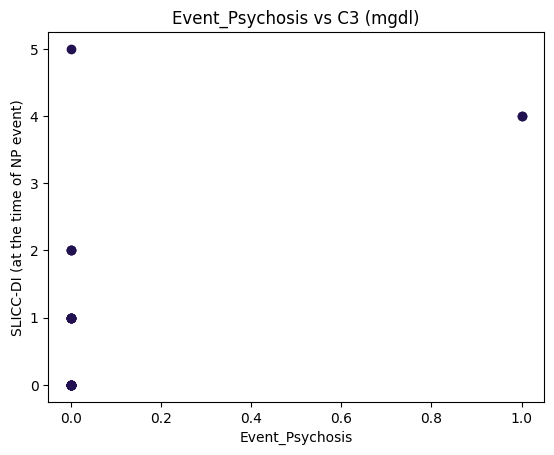

<Figure size 640x480 with 0 Axes>

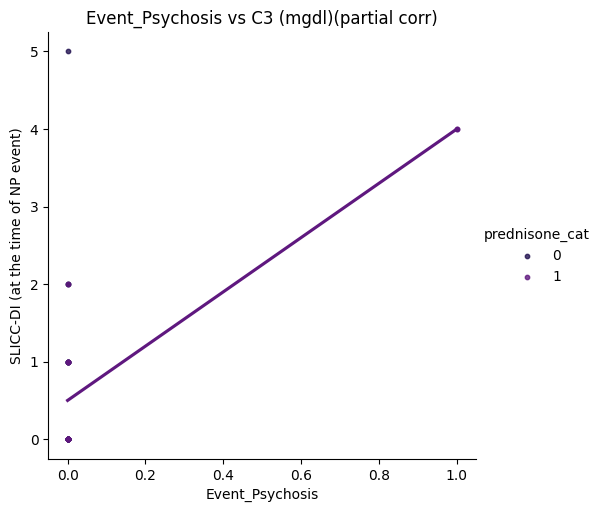

In [65]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'OpIFG total volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
slicc = 'SLICC-DI (at the time of NP event)'

## Compute the correlations
for col in neurocog_cols:
    # Compute the Pearson correlation between each neurocognitive domain and SLEDAI
    r, p = spearmanr(df[col], df[slicc])
    print(f'{col} vs {slicc}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and NP-SLE
    partial_corr_results = pg.partial_corr(data=df, x=col, y=slicc, covar=[prednisone, np_sle])
    r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
    print(f'{col} vs {slicc} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
    assert abs(r - r_partial) > 1e-10, f'{col} and {slicc} are perfectly correlated'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[slicc])
print(f'{lesion_load} vs {slicc}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=slicc, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {slicc} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


# Plot the scatter plot
plt.figure()
plt.scatter(df['Event_Psychosis'], df[slicc])
plt.xlabel('Event_Psychosis')
plt.ylabel(slicc)
plt.title('Event_Psychosis vs ' + C3)
plt.show()

# Plot the partial scatter plot
plt.figure()
sns.lmplot(data=df, x='Event_Psychosis', y=slicc, hue=prednisone, ci=None, scatter_kws={"s": 10})
plt.title('Event_Psychosis vs ' + C3 + '(partial corr)')
plt.show()


In [40]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'MPoG right volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
slicc = 'SLICC-DI (at the time of NP event)'

# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[slicc])
print(f'{lesion_load} vs {slicc}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=slicc, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {slicc} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

MPoG right volume % vs SLICC-DI (at the time of NP event): r = -0.54, p = 0.00
MPoG right volume % vs SLICC-DI (at the time of NP event) (partial corr): r = -0.37, p = 0.07


In [41]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Ventral DC left volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
slicc = 'SLICC-DI (at the time of NP event)'

# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[slicc])
print(f'{lesion_load} vs {slicc}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=slicc, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {slicc} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


Ventral DC left volume % vs SLICC-DI (at the time of NP event): r = -0.49, p = 0.01
Ventral DC left volume % vs SLICC-DI (at the time of NP event) (partial corr): r = -0.56, p = 0.00


In [42]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Insular right thickness mm'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
slicc = 'SLICC-DI (at the time of NP event)'

# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[slicc])
print(f'{lesion_load} vs {slicc}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=slicc, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {slicc} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

Insular right thickness mm vs SLICC-DI (at the time of NP event): r = -0.49, p = 0.01
Insular right thickness mm vs SLICC-DI (at the time of NP event) (partial corr): r = -0.42, p = 0.03


In [43]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'SMG total volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
slicc = 'SLICC-DI (at the time of NP event)'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[slicc])
print(f'{lesion_load} vs {slicc}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=slicc, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {slicc} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

SMG total volume % vs SLICC-DI (at the time of NP event): r = -0.51, p = 0.01
SMG total volume % vs SLICC-DI (at the time of NP event) (partial corr): r = -0.43, p = 0.03


## dsDNA

Event_CVA vs anti-dsDNA Titre  (insert NV here <7 ): r = 0.00, p = 1.00
Event_CVA vs anti-dsDNA Titre  (insert NV here <7 ) (partial corr): r = -0.14, p = 0.51
Event_Mood abnormalities (depressive) vs anti-dsDNA Titre  (insert NV here <7 ): r = 0.07, p = 0.74
Event_Mood abnormalities (depressive) vs anti-dsDNA Titre  (insert NV here <7 ) (partial corr): r = -0.24, p = 0.25
Event_Mood abnormalities (mixed) vs anti-dsDNA Titre  (insert NV here <7 ): r = 0.10, p = 0.62
Event_Mood abnormalities (mixed) vs anti-dsDNA Titre  (insert NV here <7 ) (partial corr): r = -0.10, p = 0.62
Event_Movement Disorder vs anti-dsDNA Titre  (insert NV here <7 ): r = 0.05, p = 0.80
Event_Movement Disorder vs anti-dsDNA Titre  (insert NV here <7 ) (partial corr): r = -0.12, p = 0.58
Event_Psychosis vs anti-dsDNA Titre  (insert NV here <7 ): r = 0.00, p = 1.00
Event_Psychosis vs anti-dsDNA Titre  (insert NV here <7 ) (partial corr): r = -0.15, p = 0.48
Event_Seizure vs anti-dsDNA Titre  (insert NV here <7 ): r

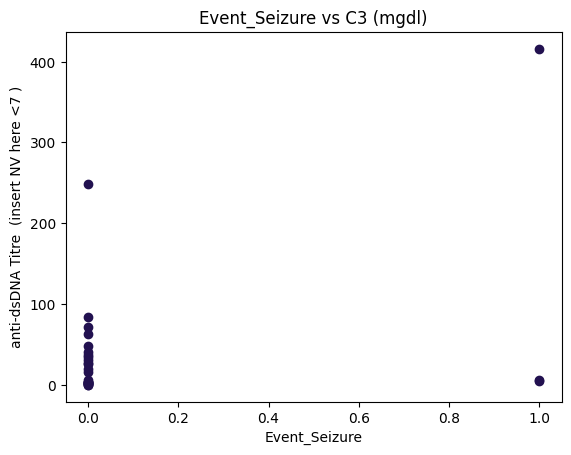

<Figure size 640x480 with 0 Axes>

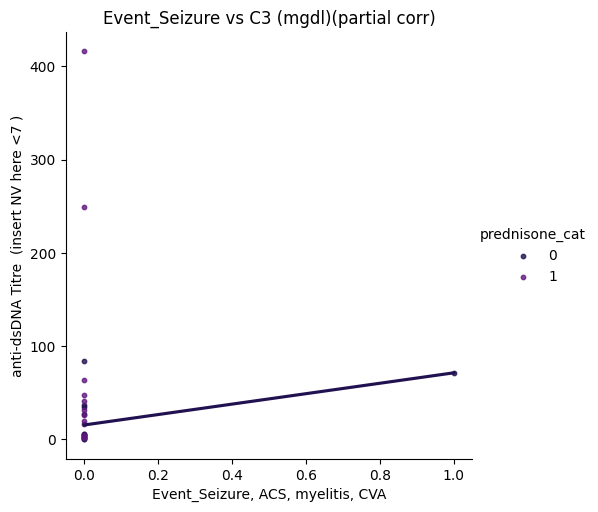

In [64]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'AOrG thickness asymmetry'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
dsDNA = 'anti-dsDNA Titre  (insert NV here <7 )'

## Compute the correlations
for col in neurocog_cols:
    # Compute the Pearson correlation between each neurocognitive domain and SLEDAI
    r, p = spearmanr(df[col], df[dsDNA])
    print(f'{col} vs {dsDNA}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and NP-SLE
    partial_corr_results = pg.partial_corr(data=df, x=col, y=dsDNA, covar=[prednisone, np_sle])
    r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
    print(f'{col} vs {dsDNA} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
    assert abs(r - r_partial) > 1e-10, f'{col} and {dsDNA} are perfectly correlated'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[dsDNA])
print(f'{lesion_load} vs {dsDNA}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=dsDNA, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {dsDNA} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


# Plot the scatter plot
plt.figure()
plt.scatter(df['Event_Seizure'], df[dsDNA])
plt.xlabel('Event_Seizure')
plt.ylabel(dsDNA)
plt.title('Event_Seizure vs ' + C3)
plt.show()

# Plot the partial scatter plot
plt.figure()
sns.lmplot(data=df, x=col, y=dsDNA, hue=prednisone, ci=None, scatter_kws={"s": 10})
plt.title('Event_Seizure vs ' + C3 + '(partial corr)')
plt.show()


In [44]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'SPL volume asymmetry'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
dsDNA = 'anti-dsDNA Titre  (insert NV here <7 )'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[dsDNA])
print(f'{lesion_load} vs {dsDNA}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=dsDNA, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {dsDNA} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


SPL volume asymmetry vs anti-dsDNA Titre  (insert NV here <7 ): r = -0.43, p = 0.03
SPL volume asymmetry vs anti-dsDNA Titre  (insert NV here <7 ) (partial corr): r = -0.01, p = 0.96


In [45]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'AnG total thickness mm'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
dsDNA = 'anti-dsDNA Titre  (insert NV here <7 )'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[dsDNA])
print(f'{lesion_load} vs {dsDNA}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=dsDNA, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {dsDNA} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

AnG total thickness mm vs anti-dsDNA Titre  (insert NV here <7 ): r = -0.43, p = 0.03
AnG total thickness mm vs anti-dsDNA Titre  (insert NV here <7 ) (partial corr): r = -0.25, p = 0.23


In [46]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'OpIFG volume asymmetry'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
dsDNA = 'anti-dsDNA Titre  (insert NV here <7 )'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[dsDNA])
print(f'{lesion_load} vs {dsDNA}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=dsDNA, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {dsDNA} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

OpIFG volume asymmetry vs anti-dsDNA Titre  (insert NV here <7 ): r = 0.42, p = 0.03
OpIFG volume asymmetry vs anti-dsDNA Titre  (insert NV here <7 ) (partial corr): r = 0.08, p = 0.69


In [47]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'AnG left thickness mm'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
dsDNA = 'anti-dsDNA Titre  (insert NV here <7 )'

# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[dsDNA])
print(f'{lesion_load} vs {dsDNA}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=dsDNA, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {dsDNA} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


AnG left thickness mm vs anti-dsDNA Titre  (insert NV here <7 ): r = -0.41, p = 0.04
AnG left thickness mm vs anti-dsDNA Titre  (insert NV here <7 ) (partial corr): r = -0.37, p = 0.07


## C3 mg/dL

Event_CVA vs C3 (mgdl): r = 0.05, p = 0.80
Event_CVA vs C3 (mgdl) (partial corr): r = 0.14, p = 0.50
Event_Mood abnormalities (depressive) vs C3 (mgdl): r = -0.22, p = 0.27
Event_Mood abnormalities (depressive) vs C3 (mgdl) (partial corr): r = -0.20, p = 0.33
Event_Mood abnormalities (mixed) vs C3 (mgdl): r = 0.28, p = 0.16
Event_Mood abnormalities (mixed) vs C3 (mgdl) (partial corr): r = 0.40, p = 0.04
Event_Movement Disorder vs C3 (mgdl): r = 0.23, p = 0.26
Event_Movement Disorder vs C3 (mgdl) (partial corr): r = 0.20, p = 0.34
Event_Psychosis vs C3 (mgdl): r = -0.23, p = 0.25
Event_Psychosis vs C3 (mgdl) (partial corr): r = -0.09, p = 0.66
Event_Seizure vs C3 (mgdl): r = -0.09, p = 0.65
Event_Seizure vs C3 (mgdl) (partial corr): r = -0.14, p = 0.49
Event_Seizure, ACS, myelitis, CVA vs C3 (mgdl): r = 0.14, p = 0.49
Event_Seizure, ACS, myelitis, CVA vs C3 (mgdl) (partial corr): r = -0.03, p = 0.89
AnG left thickness mm vs C3 (mgdl): r = 0.19, p = 0.34
AnG left thickness mm vs C3 (mgdl

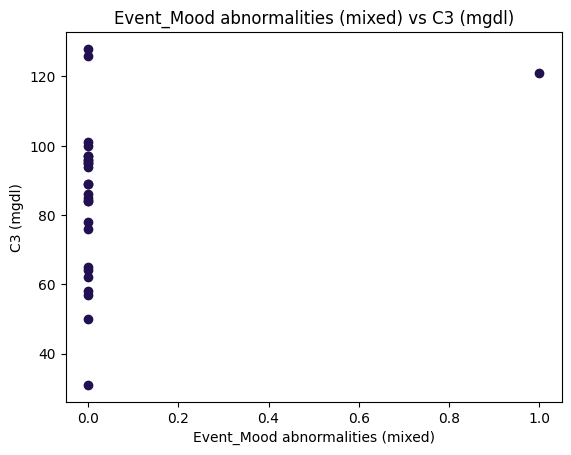

<Figure size 640x480 with 0 Axes>

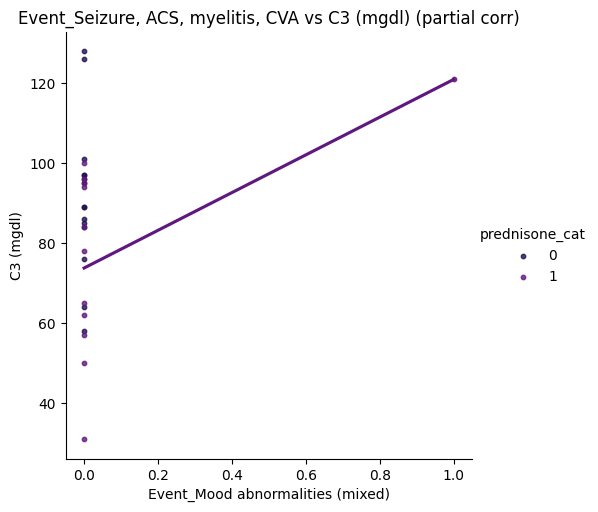

In [59]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'AnG left thickness mm'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
C3 = 'C3 (mgdl)'

## Compute the correlations
for col in neurocog_cols:
    # Compute the Pearson correlation between each neurocognitive domain and SLEDAI
    r, p = spearmanr(df[col], df[C3])
    print(f'{col} vs {C3}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and NP-SLE
    partial_corr_results = pg.partial_corr(data=df, x=col, y=C3, covar=[prednisone, np_sle])
    r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
    print(f'{col} vs {C3} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
    assert abs(r - r_partial) > 1e-10, f'{col} and {C3} are perfectly correlated'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[C3])
print(f'{lesion_load} vs {C3}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=C3, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {C3} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


# Plot the scatter plot
plt.figure()
plt.scatter(df['Event_Mood abnormalities (mixed)'], df[C3])
plt.xlabel('Event_Mood abnormalities (mixed)')
plt.ylabel(C3)
plt.title('Event_Mood abnormalities (mixed) vs ' + C3)
plt.show()

# Plot the partial scatter plot
plt.figure()
sns.lmplot(data=df, x='Event_Mood abnormalities (mixed)', y=C3, hue=prednisone, ci=None, scatter_kws={"s": 10})
plt.title(f'{col} vs {C3} (partial corr)')
plt.show()


In [48]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Calc right volume cm3'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
C3 = 'C3 (mgdl)'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[C3])
print(f'{lesion_load} vs {C3}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=C3, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {C3} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


Calc right volume cm3 vs C3 (mgdl): r = -0.56, p = 0.00
Calc right volume cm3 vs C3 (mgdl) (partial corr): r = -0.56, p = 0.00


In [49]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'Calc right volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
C3 = 'C3 (mgdl)'

# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[C3])
print(f'{lesion_load} vs {C3}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=C3, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {C3} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


Calc right volume % vs C3 (mgdl): r = -0.53, p = 0.00
Calc right volume % vs C3 (mgdl) (partial corr): r = -0.53, p = 0.01


In [50]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'PCu right thickness mm'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
C3 = 'C3 (mgdl)'
    
# Compute the Pearson correlation between MTG thickness and SLEDAI
r_mtg, p_mtg = spearmanr(df[lesion_load], df[C3])
print(f'{lesion_load} vs {C3}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=C3, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {C3} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


PCu right thickness mm vs C3 (mgdl): r = 0.52, p = 0.01
PCu right thickness mm vs C3 (mgdl) (partial corr): r = 0.46, p = 0.02


In [51]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'PHG right volume %'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
C3 = 'C3 (mgdl)'
    
# Compute the Pearson correlation between MTG thickness and C3
r_mtg, p_mtg = spearmanr(df[lesion_load], df[C3])
print(f'{lesion_load} vs {C3}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=C3, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {C3} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


PHG right volume % vs C3 (mgdl): r = -0.49, p = 0.01
PHG right volume % vs C3 (mgdl) (partial corr): r = -0.26, p = 0.20


In [52]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'MOG volume asymmetry'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
C3 = 'C3 (mgdl)'

    
# Compute the Pearson correlation between MTG thickness and C3
r_mtg, p_mtg = spearmanr(df[lesion_load], df[C3])
print(f'{lesion_load} vs {C3}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=C3, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {C3} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


MOG volume asymmetry vs C3 (mgdl): r = 0.48, p = 0.01
MOG volume asymmetry vs C3 (mgdl) (partial corr): r = 0.37, p = 0.07


## C4

Event_CVA vs C4 (mgdl): r = -0.01, p = 0.95
Event_CVA vs C4 (mgdl) (partial corr): r = 0.04, p = 0.84
Event_Mood abnormalities (depressive) vs C4 (mgdl): r = -0.03, p = 0.88
Event_Mood abnormalities (depressive) vs C4 (mgdl) (partial corr): r = -0.06, p = 0.78
Event_Mood abnormalities (mixed) vs C4 (mgdl): r = -0.18, p = 0.38
Event_Mood abnormalities (mixed) vs C4 (mgdl) (partial corr): r = -0.09, p = 0.67
Event_Movement Disorder vs C4 (mgdl): r = 0.11, p = 0.57
Event_Movement Disorder vs C4 (mgdl) (partial corr): r = 0.17, p = 0.41
Event_Psychosis vs C4 (mgdl): r = -0.07, p = 0.72
Event_Psychosis vs C4 (mgdl) (partial corr): r = 0.03, p = 0.88
Event_Seizure vs C4 (mgdl): r = 0.29, p = 0.14
Event_Seizure vs C4 (mgdl) (partial corr): r = 0.18, p = 0.40
Event_Seizure, ACS, myelitis, CVA vs C4 (mgdl): r = -0.09, p = 0.66
Event_Seizure, ACS, myelitis, CVA vs C4 (mgdl) (partial corr): r = -0.34, p = 0.09
MTG volume asymmetry vs C4 (mgdl): r = 0.54, p = 0.00
MTG volume asymmetry vs C4 (mgdl)

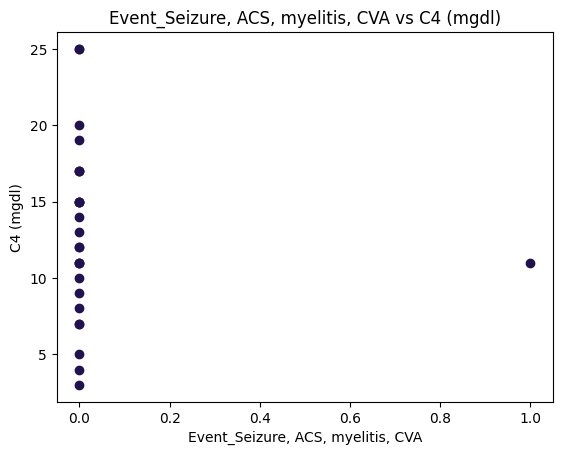

<Figure size 640x480 with 0 Axes>

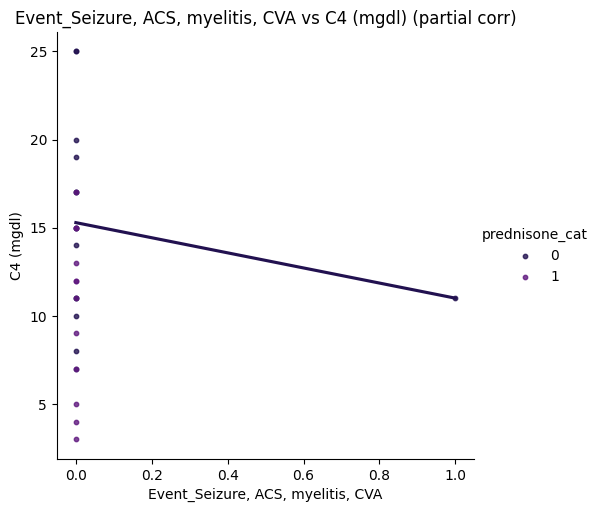

In [29]:
from scipy.stats import spearmanr
import pingouin as pg

#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'MTG volume asymmetry'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
C4 = 'C4 (mgdl)'

## Compute the correlations
for col in neurocog_cols:
    # Compute the Pearson correlation between each neurocognitive domain and C4
    r, p = spearmanr(df[col], df[C4])
    print(f'{col} vs {C4}: r = {r:.2f}, p = {p:.2f}')

    # Compute the partial correlation adjusting for prednisone and NP-SLE
    partial_corr_results = pg.partial_corr(data=df, x=col, y=C4, covar=[prednisone, np_sle])
    r_partial, p_partial = partial_corr_results['r'][0], partial_corr_results['p-val'][0]
    print(f'{col} vs {C4} (partial corr): r = {r_partial:.2f}, p = {p_partial:.2f}')
    assert abs(r - r_partial) > 1e-10, f'{col} and {C4} are perfectly correlated'
    
# Compute the Pearson correlation between MTG thickness and C4
r_mtg, p_mtg = spearmanr(df[lesion_load], df[C4])
print(f'{lesion_load} vs {C4}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=C4, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {C4} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')


# Plot the scatter plot
plt.figure()
plt.scatter(df[col], df[C4])
plt.xlabel(col)
plt.ylabel(C4)
plt.title(f'{col} vs {C4}')
plt.show()

# Plot the partial scatter plot
plt.figure()
sns.lmplot(data=df, x=col, y=C4, hue=prednisone, ci=None, scatter_kws={"s": 10})
plt.title(f'{col} vs {C4} (partial corr)')
plt.show()


In [53]:
#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'PIns total volume cm3'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
C4 = 'C4 (mgdl)'

    
# Compute the Pearson correlation between MTG thickness and C4
r_mtg, p_mtg = spearmanr(df[lesion_load], df[C4])
print(f'{lesion_load} vs {C4}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=C4, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {C4} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

PIns total volume cm3 vs C4 (mgdl): r = 0.54, p = 0.00
PIns total volume cm3 vs C4 (mgdl) (partial corr): r = 0.47, p = 0.02


In [54]:
#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'FRP right volume cm3'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
C4 = 'C4 (mgdl)'

# Compute the Pearson correlation between MTG thickness and C4
r_mtg, p_mtg = spearmanr(df[lesion_load], df[C4])
print(f'{lesion_load} vs {C4}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=C4, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {C4} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

FRP right volume cm3 vs C4 (mgdl): r = 0.55, p = 0.00
FRP right volume cm3 vs C4 (mgdl) (partial corr): r = 0.39, p = 0.06


In [55]:
#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'PIns left volume cm3'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
C4 = 'C4 (mgdl)'
    
# Compute the Pearson correlation between MTG thickness and C4
r_mtg, p_mtg = spearmanr(df[lesion_load], df[C4])
print(f'{lesion_load} vs {C4}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=C4, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {C4} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

PIns left volume cm3 vs C4 (mgdl): r = 0.60, p = 0.00
PIns left volume cm3 vs C4 (mgdl) (partial corr): r = 0.53, p = 0.01


In [56]:
#df['SLEDAI_cat'] = np.where(df['SLEDAI-2k (at the time of NP event)'] > df['SLEDAI-2k (at the time of NP event)'].median(), 1, 0)
df['prednisone_cat'] = np.where(df['Prednisone  (mg equivalent)'] > df['Prednisone  (mg equivalent)'].median(), 1, 0)

# Define the variables
neurocog_cols = ['Event_CVA', 'Event_Mood abnormalities (depressive)', 'Event_Mood abnormalities (mixed)', 'Event_Movement Disorder', 'Event_Psychosis','Event_Seizure','Event_Seizure, ACS, myelitis, CVA']
lesion_load = 'ITG thickness asymmetry'
prednisone = 'prednisone_cat'
np_sle = 'NP-SLE'
C4 = 'C4 (mgdl)'
    
# Compute the Pearson correlation between MTG thickness and C4
r_mtg, p_mtg = spearmanr(df[lesion_load], df[C4])
print(f'{lesion_load} vs {C4}: r = {r_mtg:.2f}, p = {p_mtg:.2f}')

# Compute the partial correlation adjusting for prednisone and NP-SLE
partial_corr_mtg_results = pg.partial_corr(data=df, x=lesion_load, y=C4, covar=[prednisone, np_sle])
r_mtg_partial, p_mtg_partial = partial_corr_mtg_results['r'][0], partial_corr_mtg_results['p-val'][0]
print(f'{lesion_load} vs {C4} (partial corr): r = {r_mtg_partial:.2f}, p = {p_mtg_partial:.2f}')

ITG thickness asymmetry vs C4 (mgdl): r = 0.67, p = 0.00
ITG thickness asymmetry vs C4 (mgdl) (partial corr): r = 0.56, p = 0.00
